### Module

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

### Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# train.drop(['purpose4'], axis = 1, inplace = True)

In [4]:
def numeric(df):
    return df.select_dtypes(include = np.number).columns

def categoric(df):
    return df.select_dtypes(exclude = np.number).columns

### EDA

In [5]:
df = train.copy()

In [6]:
numeric(df)

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'emp_length1',
       'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5',
       'emp_length6', 'emp_length7', 'emp_length8', 'emp_length9',
       'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1',
       'home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6', 'verification_status1',
       'verification_status2', 'verification_status3', 'purpose1', 'purpose2',
       'purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8',
       'purpose9', 'purpose10', 'purpose11', 'purpose12', 'purpose13',
       'purpose14', 'initial_list_status1', 'initial_list_status2',
       'mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_l

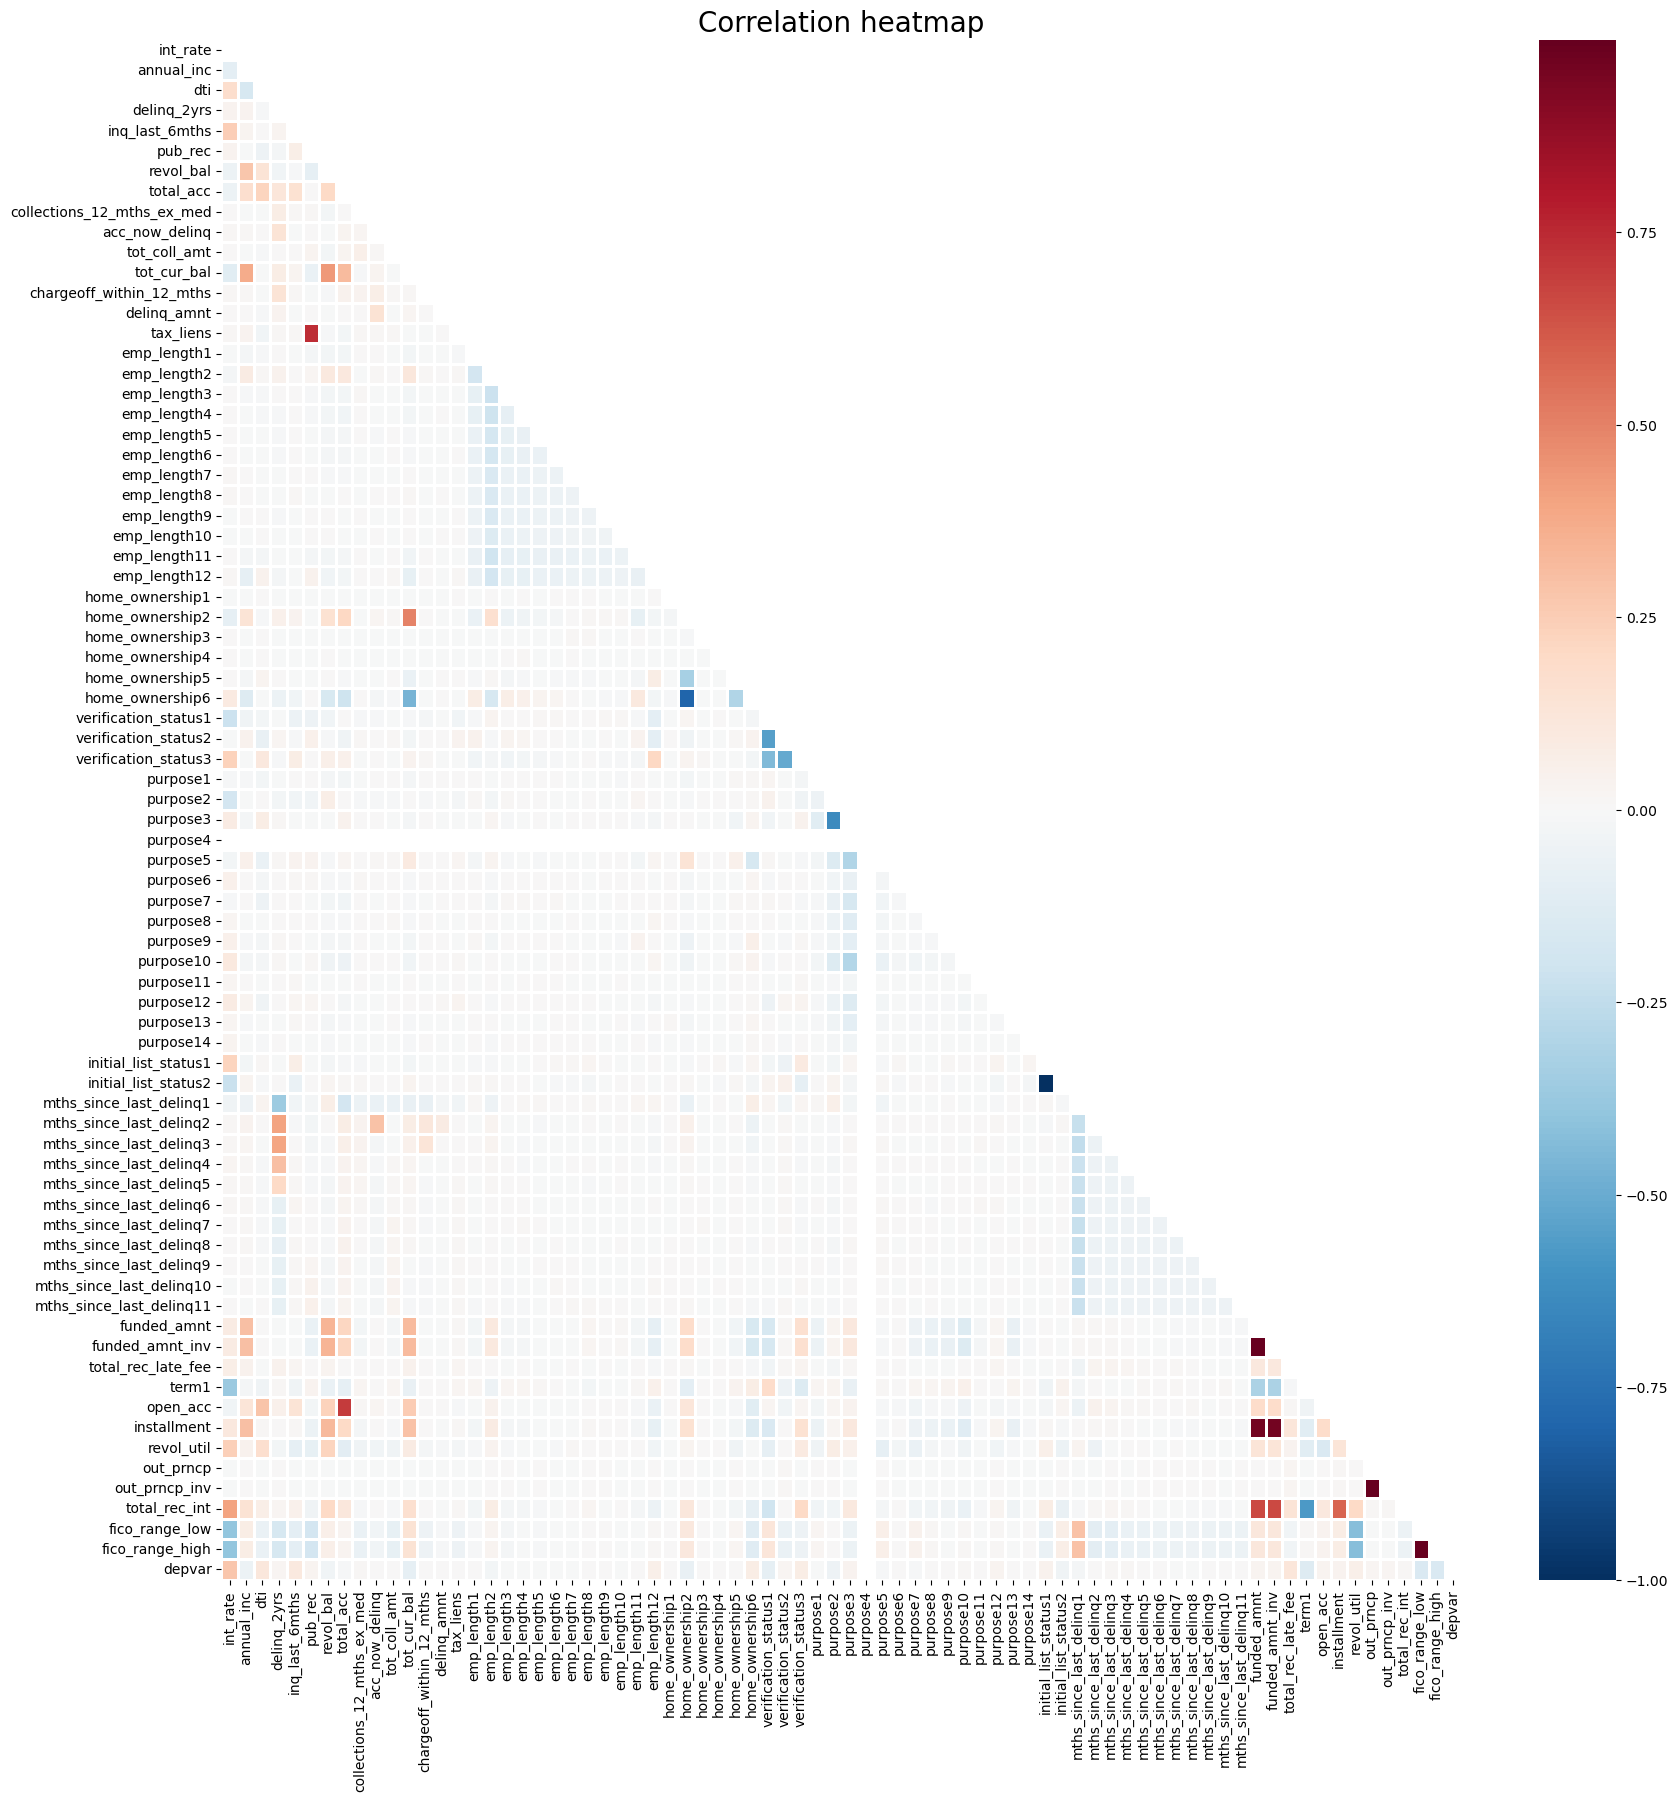

In [10]:
plt.figure(figsize=(20,20))

df_cor = df.corr(method = 'pearson')
mask = np.zeros_like(df_cor, dtype = np.number)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_cor, 
           cmap = 'RdBu_r',
           linewidth = 2, 
           mask = mask)

plt.title('Correlation heatmap', fontsize=20)
plt.show()

In [9]:
# 상관성 쳌
# FE : 상관성이 높은 피처들을 활용 해봐야겠구나 정도 생각
df.corr()['depvar'].to_frame().sort_values(by = 'depvar', ascending=False).head(10)

,depvar
depvar,1.000000
int_rate,0.277944
total_rec_late_fee,0.123072
dti,0.110809
inq_last_6mths,0.096474
home_ownership6,0.074905
verification_status3,0.070785
emp_length12,0.056912
revol_util,0.055833
initial_list_status1,0.044515


### mths_since_last_delinq1 ~ 11 : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)

In [10]:
fc = [col for col in df.columns if 'mths_since_last_delinq' in col] + ['depvar']
df1 = df[fc]

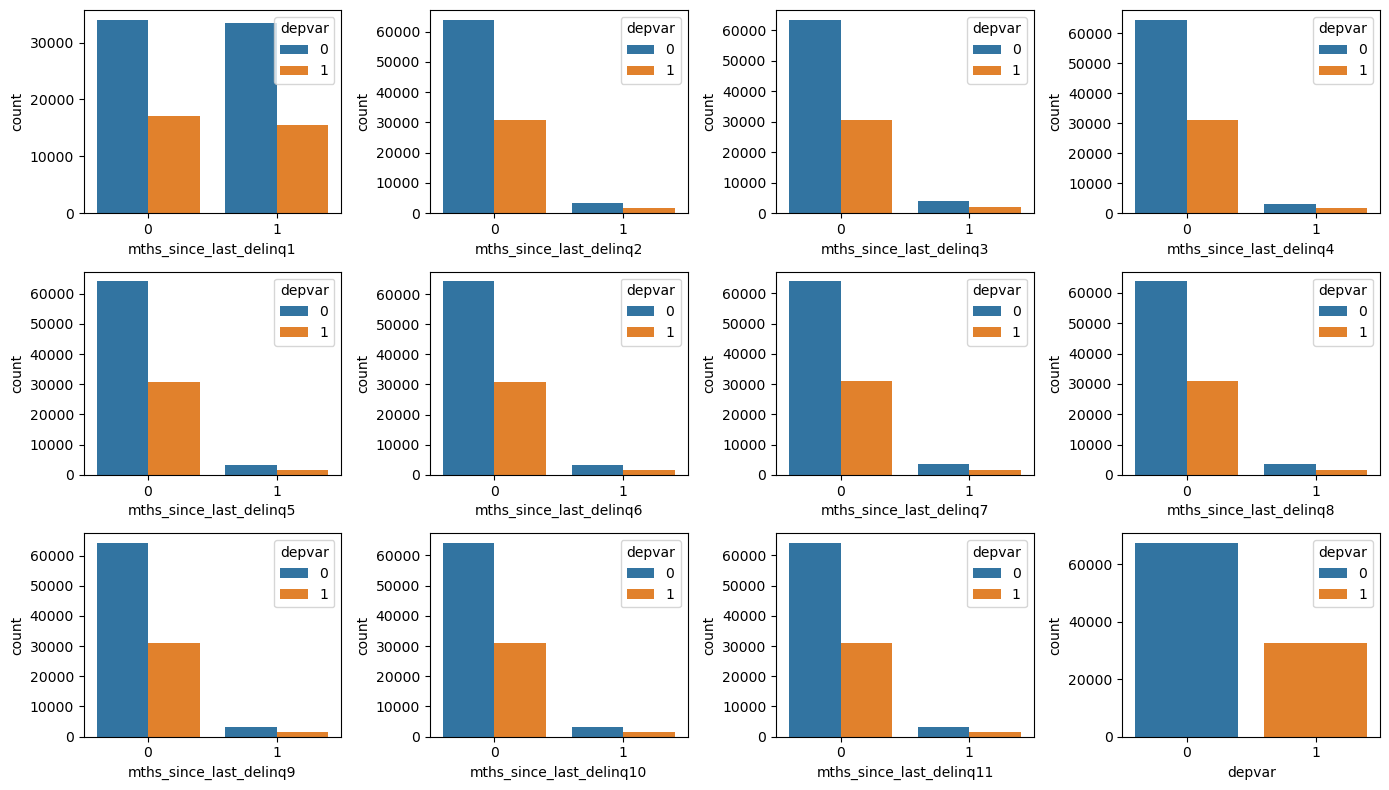

In [11]:
fig, axs = plt.subplots(3, 4, figsize = (14, 8))

for i, column in enumerate(numeric(df1)):
    row, col = i // 4, i % 4
    sns.countplot(data = df1, x = column, hue='depvar', ax = axs[row, col])
    
plt.tight_layout()
plt.show()

In [12]:
def get_mths_since_last_delinq(row):
    for i in range(1, 12):
        if row[f'mths_since_last_delinq{i}'] == 1:
            return i
    return 0  

def mths_since_last_delinq_length(df):
    df['mths_since_last_delinq_length'] = df.apply(get_mths_since_last_delinq, axis=1)
    df.drop(columns= ['mths_since_last_delinq1', 'mths_since_last_delinq2',
       'mths_since_last_delinq3', 'mths_since_last_delinq4',
       'mths_since_last_delinq5', 'mths_since_last_delinq6',
       'mths_since_last_delinq7', 'mths_since_last_delinq8',
       'mths_since_last_delinq9', 'mths_since_last_delinq10',
       'mths_since_last_delinq11'], axis = 1, inplace = True)
    
mths_since_last_delinq_length(df1)
df1.head()

,depvar,mths_since_last_delinq_length
0,0,1
1,0,1
2,0,11
3,1,5
4,1,1


mths_since_last_delinq1 : 31.711 %
mths_since_last_delinq2 : 33.728 %
mths_since_last_delinq3 : 34.149 %
mths_since_last_delinq4 : 35.361 %
mths_since_last_delinq5 : 33.222 %
mths_since_last_delinq6 : 33.587 %
mths_since_last_delinq7 : 31.808 %
mths_since_last_delinq8 : 32.154 %
mths_since_last_delinq9 : 33.435 %
mths_since_last_delinq10 : 33.640 %
mths_since_last_delinq11 : 32.956 %


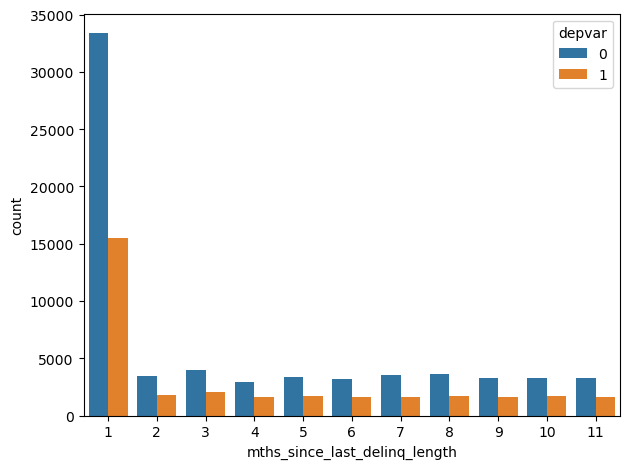

In [13]:
data = {}
for i in range(1, 12):
    col = f'mths_since_last_delinq{i}'
    cond = df1['mths_since_last_delinq_length'] == i
    result = len(df1[cond][df1['depvar'] == 1]) / len(df1[cond]) * 100
    print('{} : {:.3f} %'.format(col, result))
    data[col] = result
    
sns.countplot(data = df1, x = 'mths_since_last_delinq_length', hue = 'depvar')
plt.tight_layout()
plt.show()

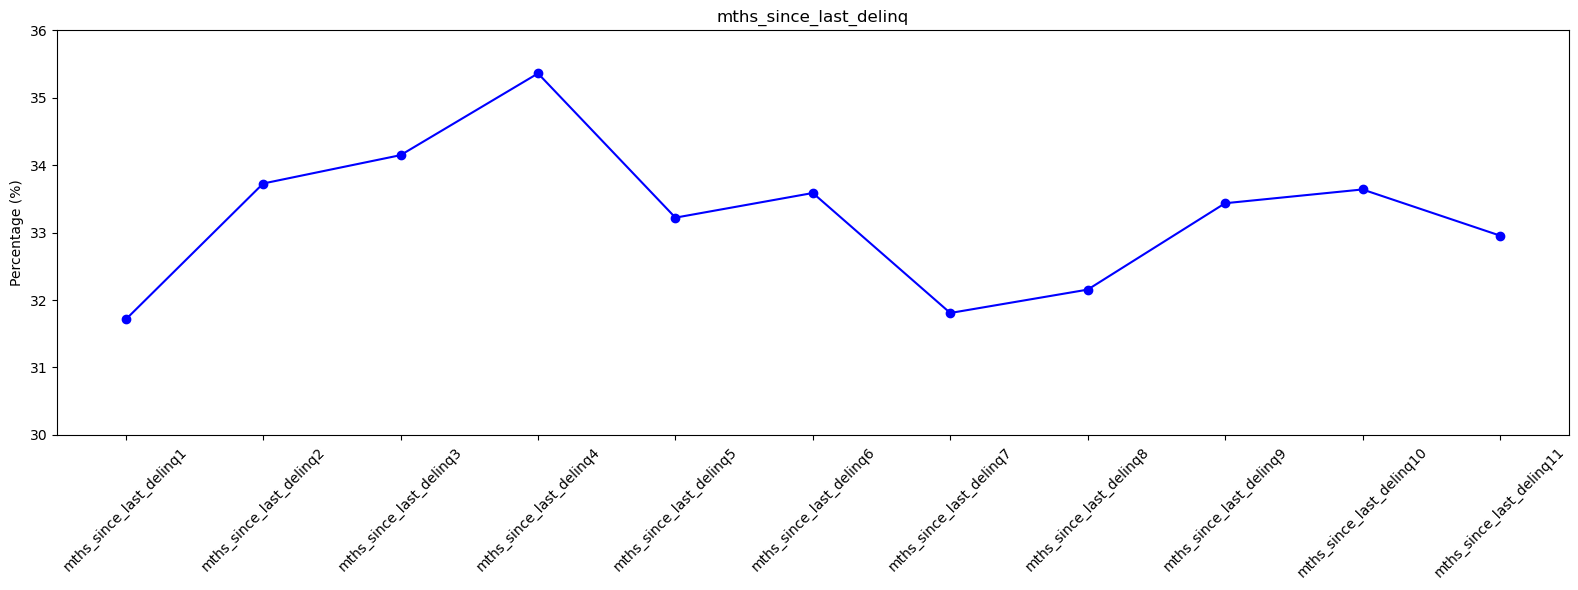

In [14]:
# 3개월 주기로 체납자 비율이 증가 감소하는데 유효한지는 모르겠음

df_data = pd.DataFrame(list(data.items()), columns=['mths', 'percent'])

plt.figure(figsize=(16, 6))
plt.plot(df_data['mths'], df_data['percent'], marker='o', linestyle='-', color='b')
plt.ylabel('Percentage (%)')
plt.title('mths_since_last_delinq')
plt.xticks(rotation=45)
plt.ylim(30, 36)
plt.tight_layout()
plt.show()

### emp_length1 ~ 12 : 고용 연수 (Number of years in the job)

In [15]:
fc = [col for col in df.columns if 'emp_length' in col] + ['depvar']
df2 = df[fc]

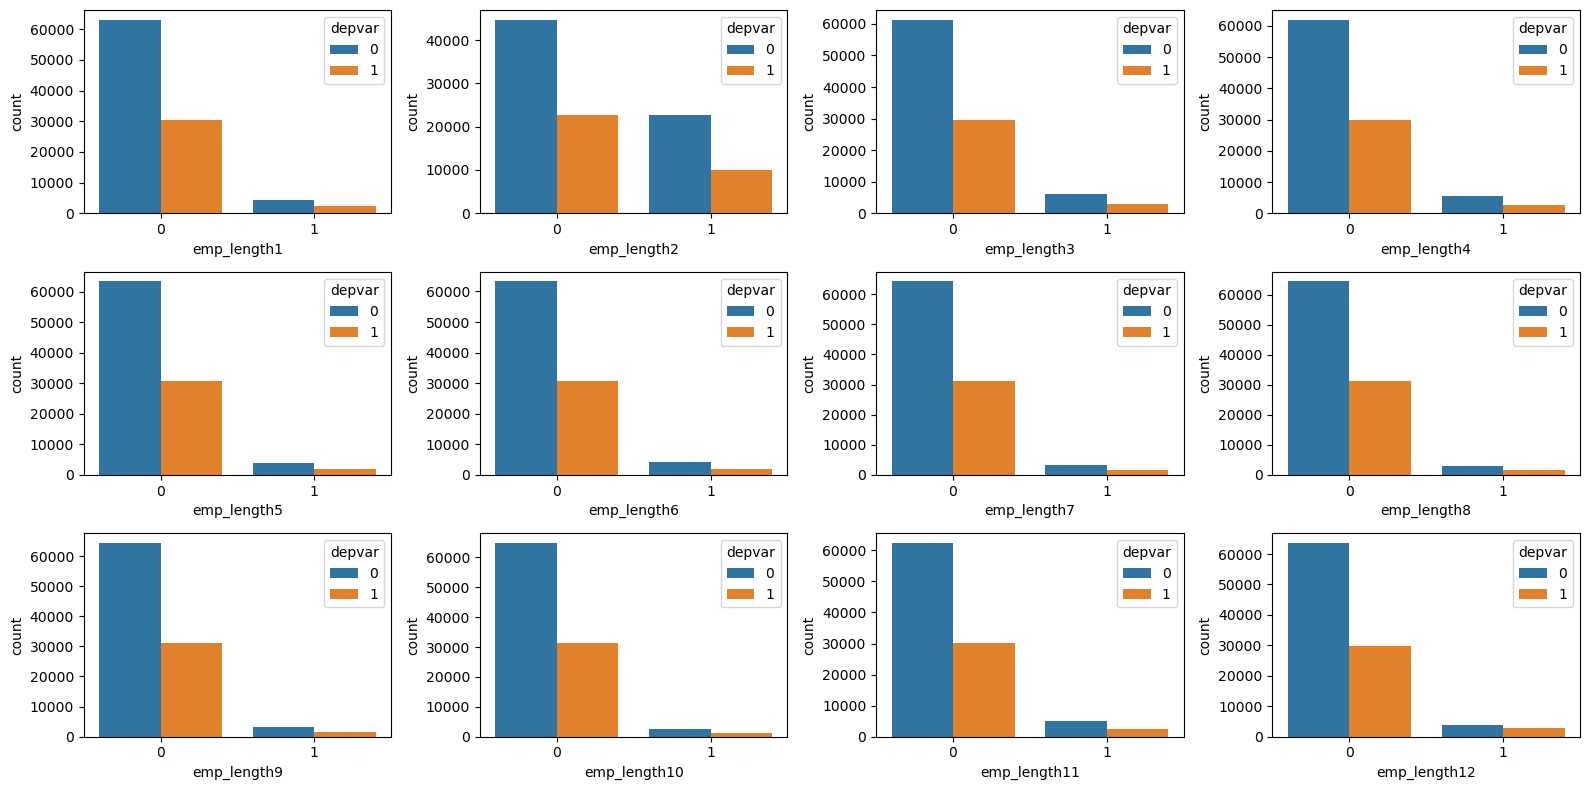

In [16]:
fig, axs = plt.subplots(3, 4, figsize = (16, 8))

for i, column in enumerate(numeric(df2)[:-1]):
    row, col = i // 4, i % 4
    sns.countplot(data = df2, x = column, hue='depvar', ax = axs[row, col])
    
plt.tight_layout()
plt.show()

In [17]:
def get_emp_length(row):
    for i in range(1, 13):
        if row[f'emp_length{i}'] == 1:
            return i
    return 0  

def emp_length(df):
    df['emp_length'] = df.apply(get_emp_length, axis=1)
    df.drop(columns= ['emp_length1',
       'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5',
       'emp_length6', 'emp_length7', 'emp_length8', 'emp_length9',
       'emp_length10', 'emp_length11', 'emp_length12'], axis = 1, inplace = True)
    
emp_length(df2)
df2.head()

,depvar,emp_length
0,0,1
1,0,2
2,0,4
3,1,3
4,1,4


emp_length1 : 33.685 %
emp_length2 : 30.484 %
emp_length3 : 32.021 %
emp_length4 : 32.266 %
emp_length5 : 32.330 %
emp_length6 : 32.038 %
emp_length7 : 31.604 %
emp_length8 : 32.944 %
emp_length9 : 33.290 %
emp_length10 : 32.460 %
emp_length11 : 33.395 %
emp_length12 : 42.569 %


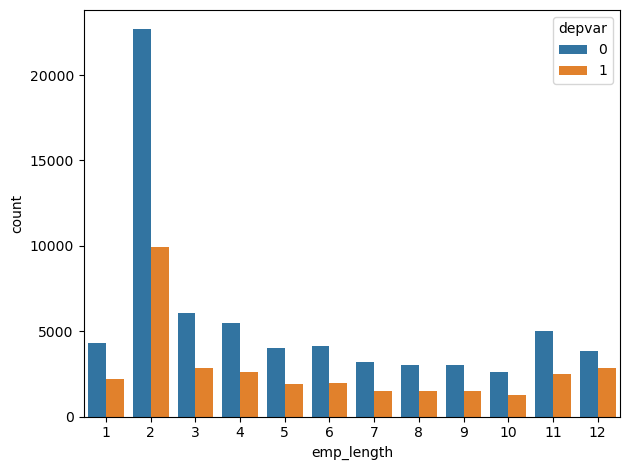

In [18]:
data = {}
    
for i in range(1, 13):
    col = f'emp_length{i}'
    cond = df2['emp_length'] == i
    result = len(df2[cond][df2['depvar'] == 1]) / len(df2[cond]) * 100
    print('{} : {:.3f} %'.format(col, result))
    data[col] = result

sns.countplot(data = df2, x = 'emp_length', hue = 'depvar')
plt.tight_layout()
plt.show()

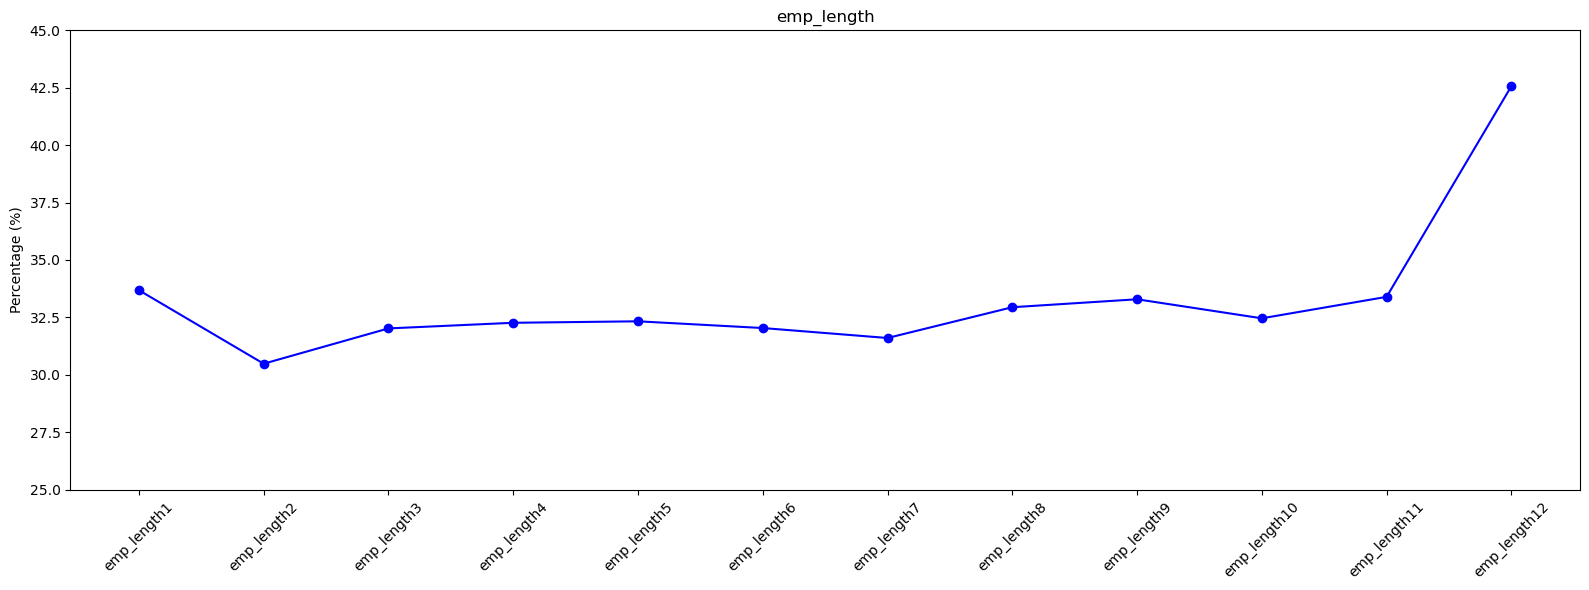

In [19]:
# 고용년수와 체납자 비율은 상관없어 보이지만 
# 12개월 일때 급상승 하는 모습을 확인 할 수 있음

df_data = pd.DataFrame(list(data.items()), columns=['emp', 'percent'])

plt.figure(figsize=(16, 6))
plt.plot(df_data['emp'], df_data['percent'], marker='o', linestyle='-', color='b')
plt.ylabel('Percentage (%)')
plt.title('emp_length')
plt.xticks(rotation=45)
plt.ylim(25, 45)
plt.tight_layout()
plt.show()


### purpose1 ~ 14 : 대출 목적 (The purpose of the loan)

In [20]:
fc = [col for col in df.columns if 'purpose' in col] + ['depvar']
df3 = df[fc]
df3.head()

,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,depvar
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


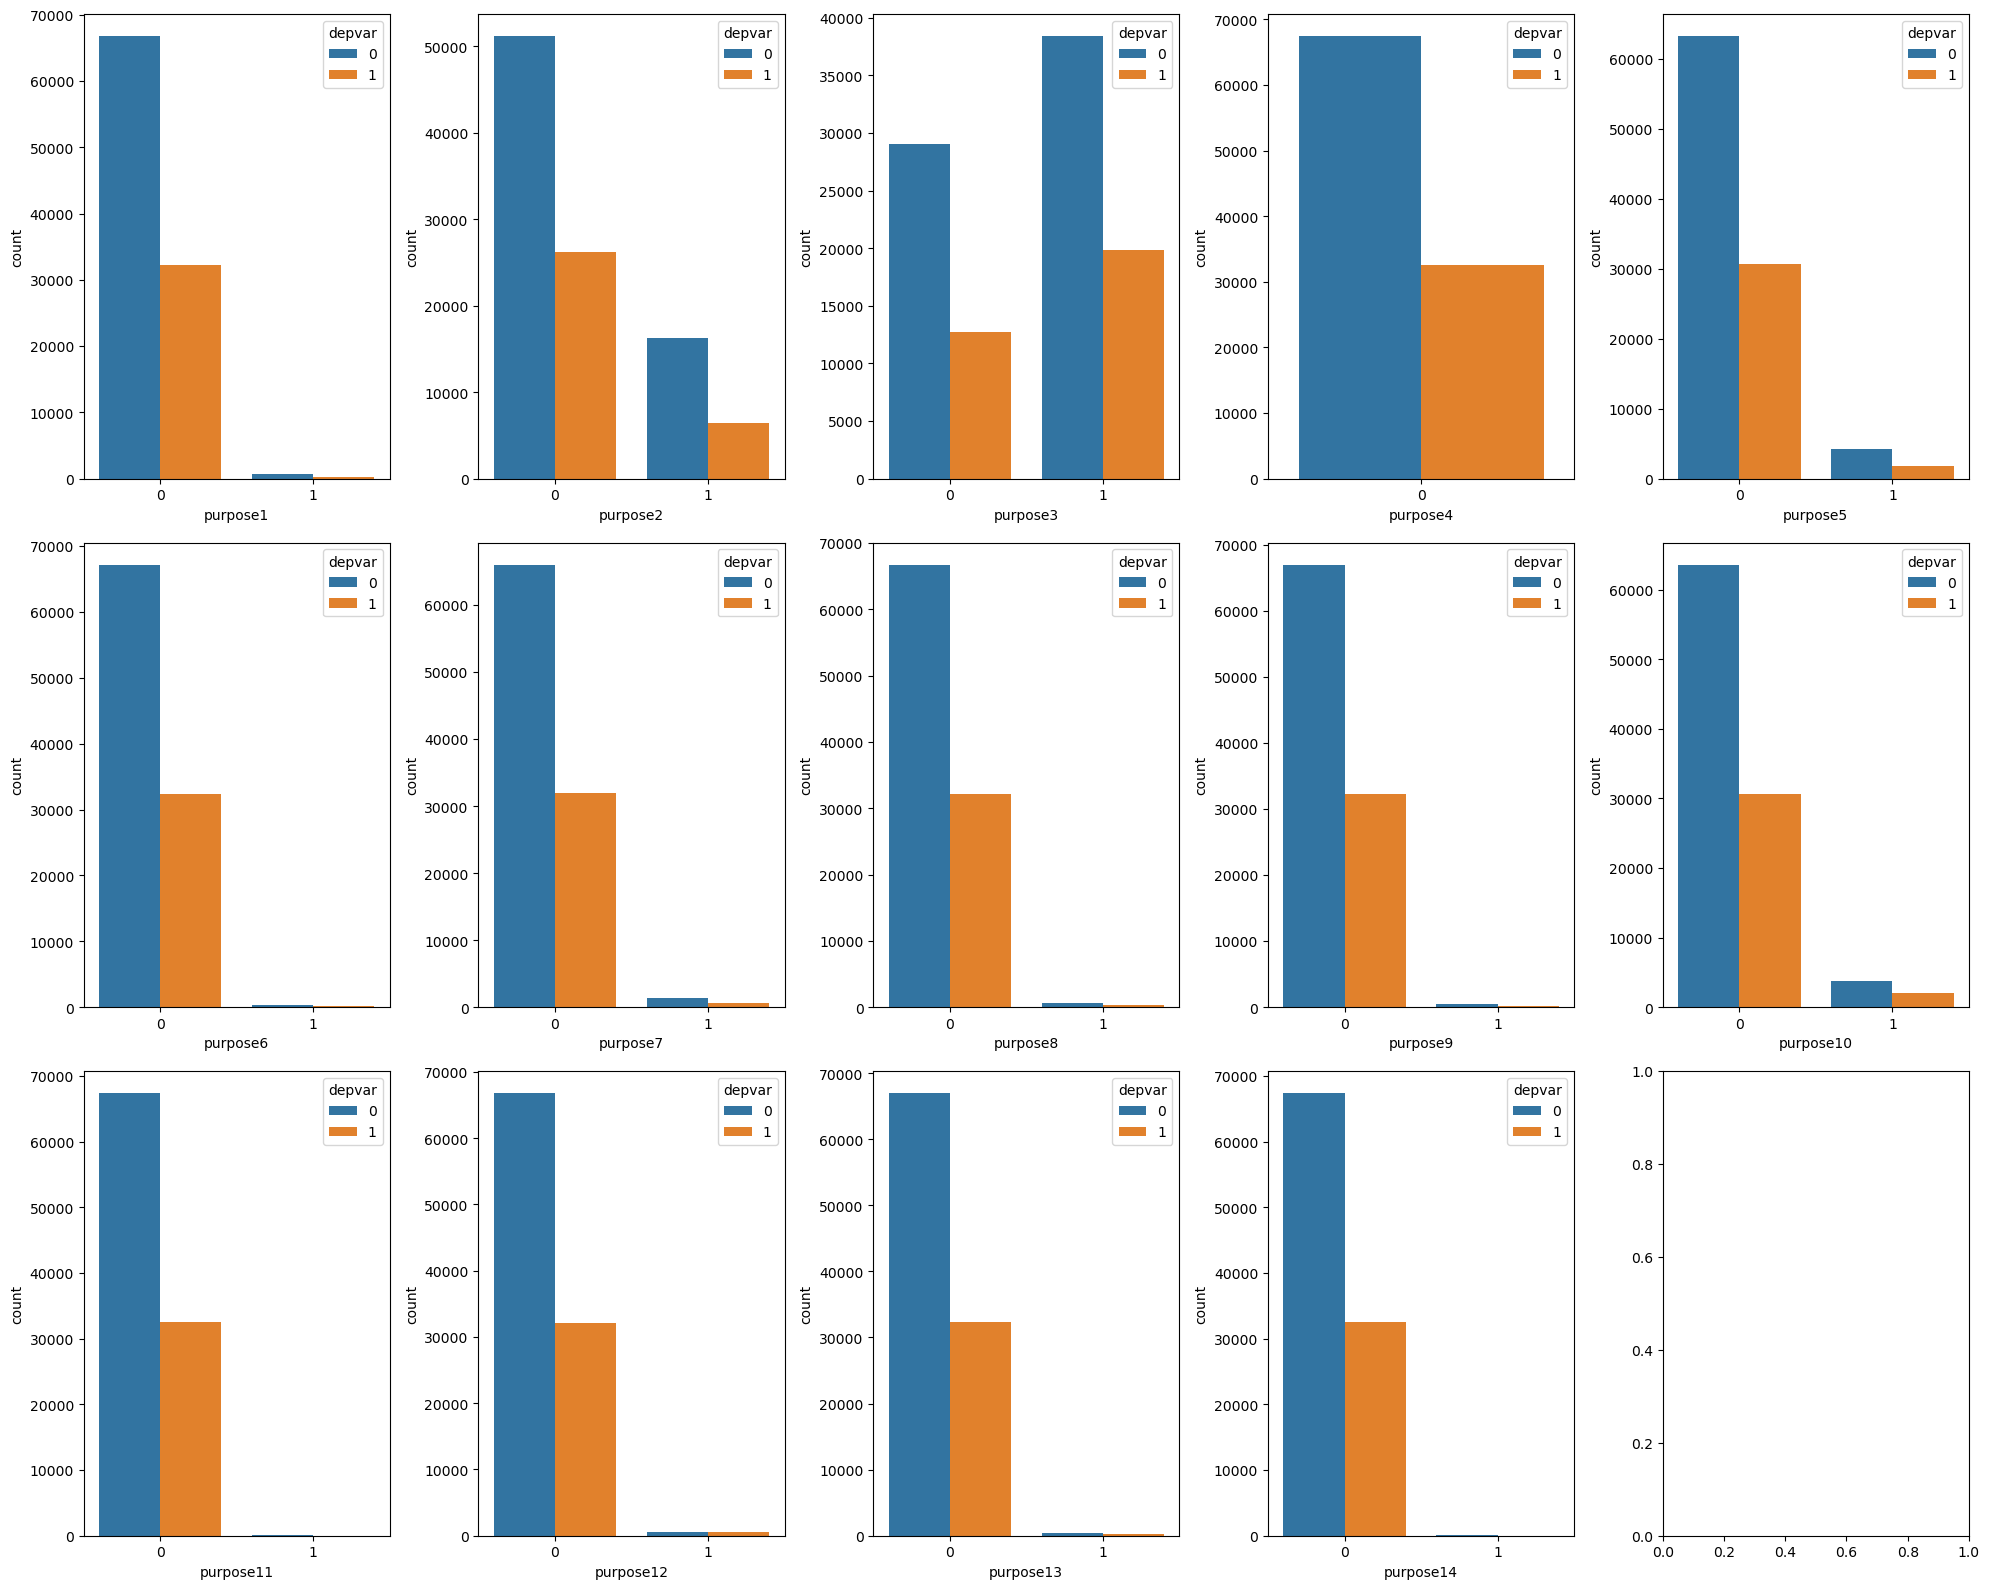

In [21]:
fig, axs = plt.subplots(3, 5, figsize = (20, 16))

for i, column in enumerate(numeric(df3)[:-1]):
    row, col = i // 5, i % 5
    sns.countplot(data = df3, x = column, hue='depvar', ax = axs[row, col])
    
plt.tight_layout()
plt.show()

In [22]:
def get_purpose_length(row):
    for i in range(1, 15):
        if row[f'purpose{i}'] == 1:
            return i
    return 0  

def purpose_length(df):
    df['purpose_length'] = df.apply(get_purpose_length, axis=1)
    df.drop(columns= ['purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6',        'purpose7',
       'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12',
       'purpose13', 'purpose14'], axis = 1, inplace = True)
    
purpose_length(df3)
df3.head()

,depvar,purpose_length
0,0,2
1,0,3
2,0,3
3,1,3
4,1,3


purpose1 : 29.834 %
purpose2 : 28.237 %
purpose3 : 34.105 %
purpose5 : 30.364 %
purpose6 : 37.176 %
purpose7 : 29.299 %
purpose8 : 35.332 %
purpose9 : 35.157 %
purpose10 : 34.158 %
purpose11 : 35.385 %
purpose12 : 43.911 %
purpose13 : 35.361 %
purpose14 : 32.955 %


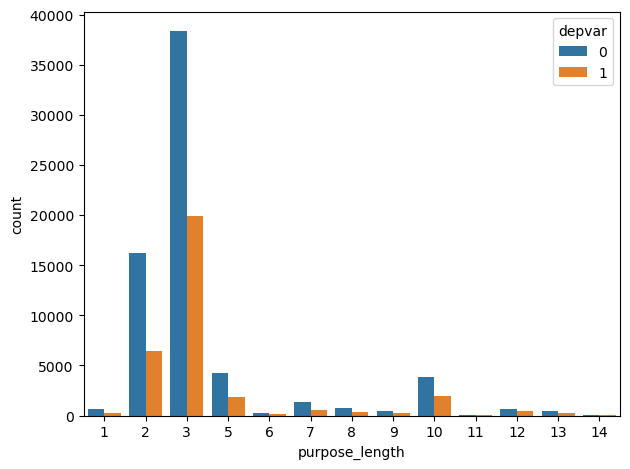

In [23]:
data = {}
for i in range(1, 15):
    if i == 4: continue
    col = f'purpose{i}'
    cond = df3['purpose_length'] == i
    result = len(df3[cond][df3['depvar'] == 1]) / len(df3[cond]) * 100
    print('{} : {:.3f} %'.format(col, result))
    data[col] = result

sns.countplot(data = df3, x = 'purpose_length', hue = 'depvar')
plt.tight_layout()
plt.show()

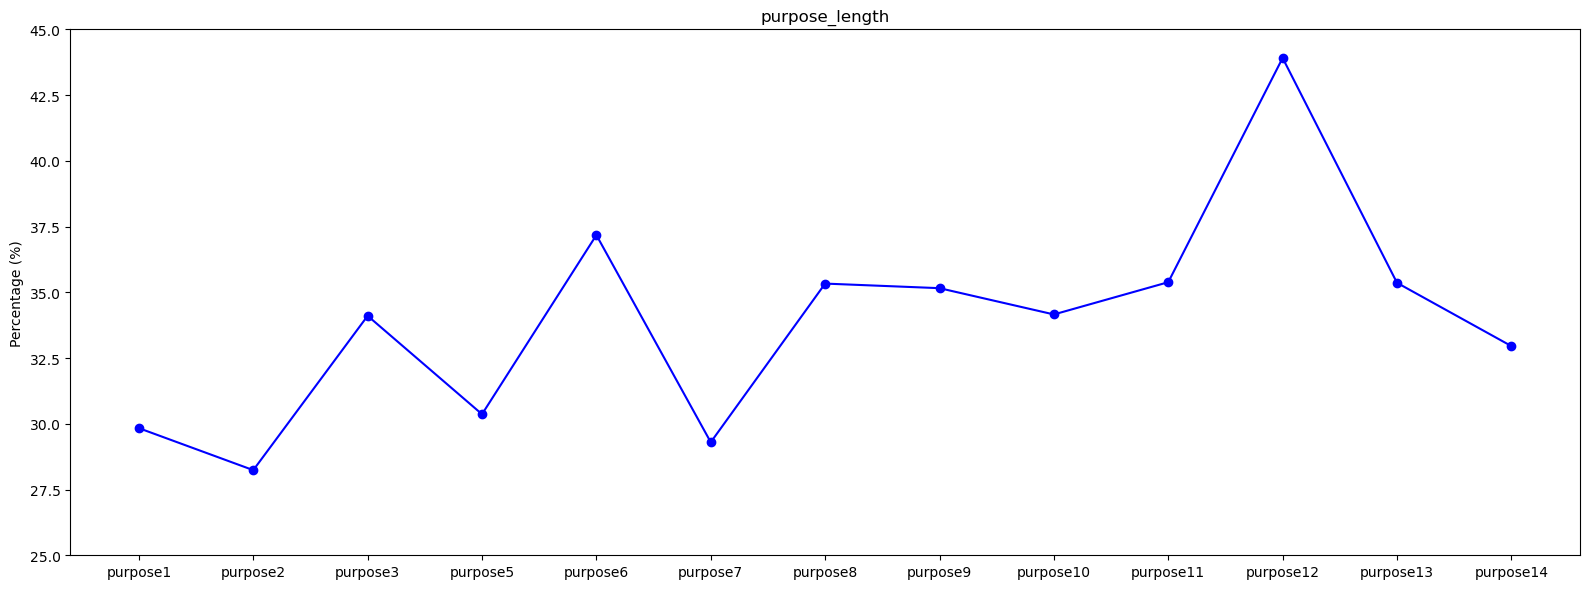

In [24]:
# 12번 대출상품은 위험한 듯
# 2, 5, 7 번 상품은 비교적 안전

df_data = pd.DataFrame(list(data.items()), columns=['purpose', 'percent'])

plt.figure(figsize=(16, 6))
plt.plot(df_data['purpose'], df_data['percent'], marker='o', linestyle='-', color='b')
plt.ylabel('Percentage (%)')
plt.title('purpose_length')
plt.ylim(25, 45)
plt.tight_layout()
plt.show()

### home_ownership1 ~ 6 : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)

In [25]:
fc = [col for col in df.columns if 'home_ownership' in col] + ['depvar']
df4 = df[fc]
df4.head()

,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,depvar
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1
4,0,0,0,0,0,1,1


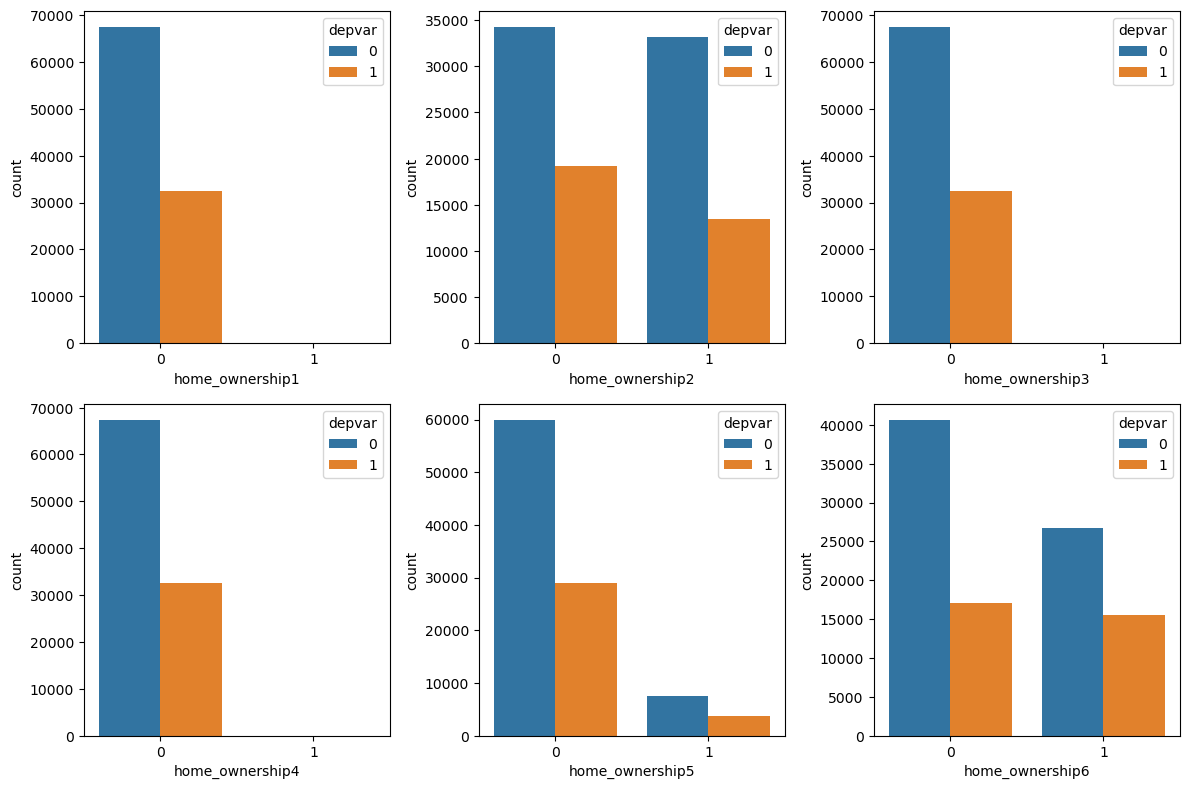

In [26]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))

for i, column in enumerate(numeric(df4)[:-1]):
    row, col = i // 3, i % 3
    sns.countplot(data = df4, x = column, hue='depvar', ax = axs[row, col])
    
plt.tight_layout()
plt.show()

In [27]:
def get_home_ownership_length(row):
    for i in range(1, 7):
        if row[f'home_ownership{i}'] == 1:
            return i
    return 0  

def home_ownership_length(df):
    df['home_ownership_length'] = df.apply(get_home_ownership_length, axis=1)
    df.drop(columns= ['home_ownership1','home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6'], axis = 1, inplace = True)
    
home_ownership_length(df4)
df4.head()

,depvar,home_ownership_length
0,0,6
1,0,6
2,0,6
3,1,2
4,1,6


home_ownership1 : 33.333 %
home_ownership2 : 28.799 %
home_ownership3 : 42.857 %
home_ownership4 : 40.000 %
home_ownership5 : 32.765 %
home_ownership6 : 36.673 %


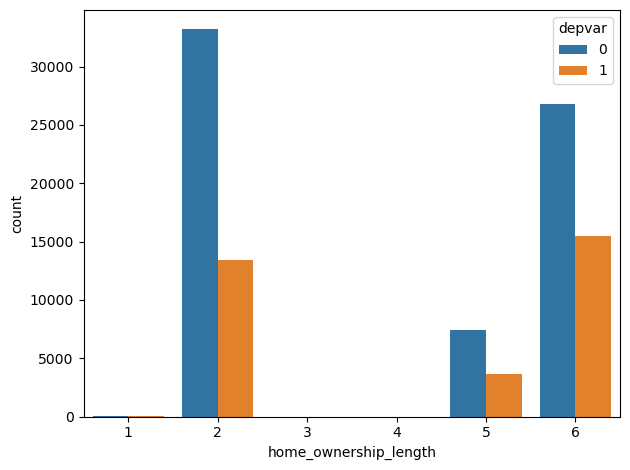

In [28]:
data = {}
for i in range(1, 7):
    col = f'home_ownership{i}'
    cond = df4['home_ownership_length'] == i
    result = len(df4[cond][df4['depvar'] == 1]) / len(df4[cond]) * 100
    print('{} : {:.3f} %'.format(col, result))
    data[col] = result


sns.countplot(data = df4, x = 'home_ownership_length', hue = 'depvar')
plt.tight_layout()
plt.show()

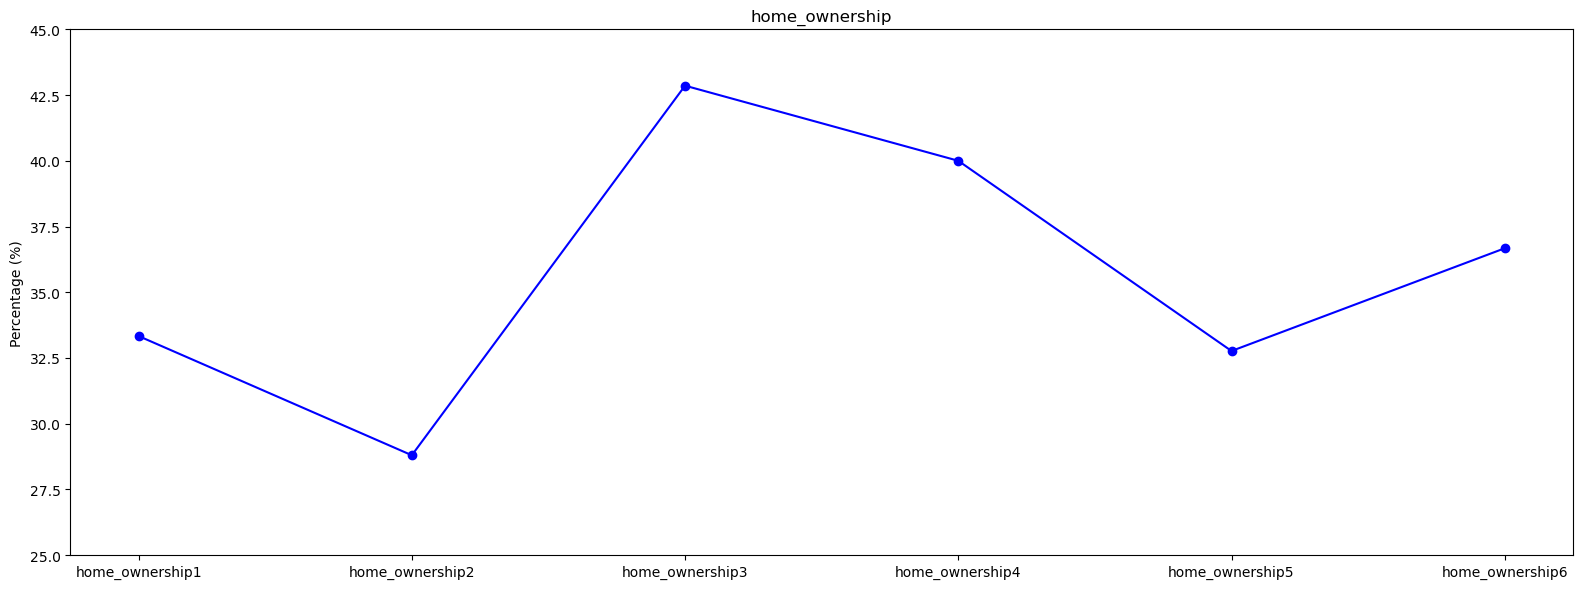

In [29]:
# 3번 주거형태의 경우 체납자 비율이 높음
# 3번 주거형태 + 12번 대출상품을 이용하는 사람 ? -? 넌 부도야 
df_data = pd.DataFrame(list(data.items()), columns=['home_ownership', 'percent'])

plt.figure(figsize=(16, 6))
plt.plot(df_data['home_ownership'], df_data['percent'], marker='o', linestyle='-', color='b')
plt.ylabel('Percentage (%)')
plt.title('home_ownership')
plt.ylim(25, 45)
plt.tight_layout()
plt.show()

### verification_status1 ~ 3 : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)

In [30]:
fc = [col for col in df.columns if 'verification_status' in col] + ['depvar']
df5 = df[fc]
df5.head()

,verification_status1,verification_status2,verification_status3,depvar
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,1
4,0,1,0,1


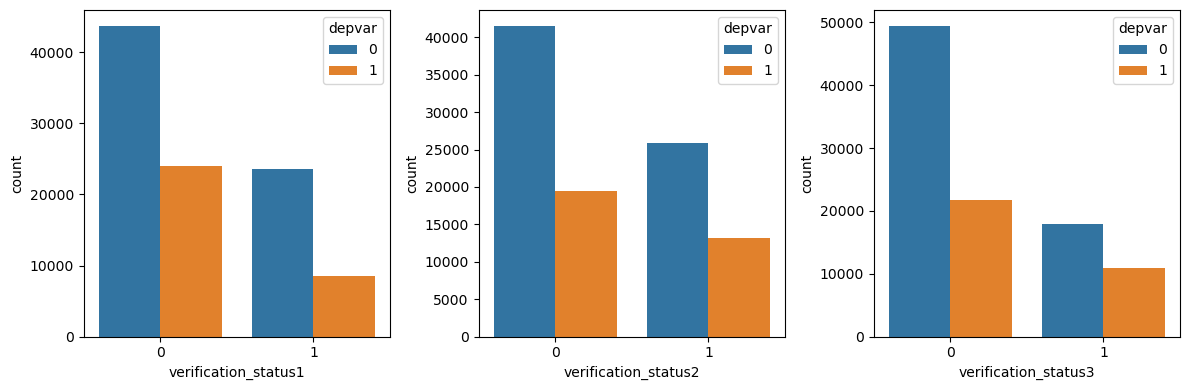

In [31]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))

for i, column in enumerate(numeric(df5)[:-1]):
    row, col = i // 3, i % 3
    sns.countplot(data = df5, x = column, hue='depvar', ax = axs[col])
    
plt.tight_layout()
plt.show()

In [32]:
def get_verification_status_length(row):
    for i in range(1, 4):
        if row[f'verification_status{i}'] == 1:
            return i
    return 0  

def verification_status_length(df):
    df['verification_status_length'] = df.apply(get_verification_status_length, axis=1)
    df.drop(columns= ['verification_status1','verification_status2', 'verification_status3'], axis = 1, inplace = True)
    
verification_status_length(df5)
df5.head()

,depvar,verification_status_length
0,0,2
1,0,3
2,0,2
3,1,3
4,1,2


verification_status_length1 : 26.498 %
verification_status_length2 : 33.726 %
verification_status_length3 : 37.785 %


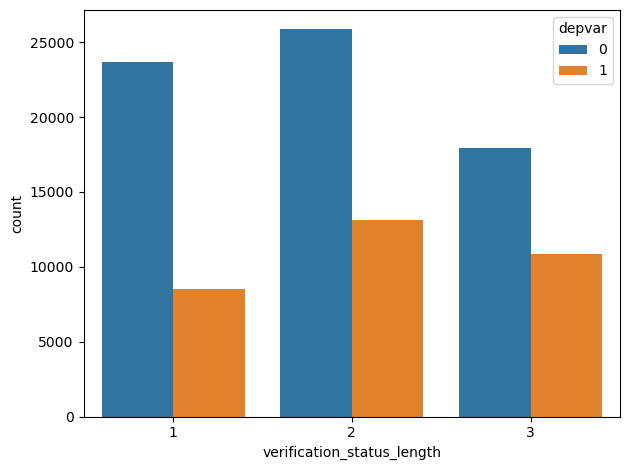

In [33]:
data = {}
    
for i in range(1, 4):
    col = f'verification_status_length{i}'
    cond = df5['verification_status_length'] == i
    result = len(df5[cond][df5['depvar'] == 1]) / len(df5[cond]) * 100
    print('{} : {:.3f} %'.format(col, result))
    data[col] = result

sns.countplot(data = df5, x = 'verification_status_length', hue = 'depvar')
plt.tight_layout()
plt.show()

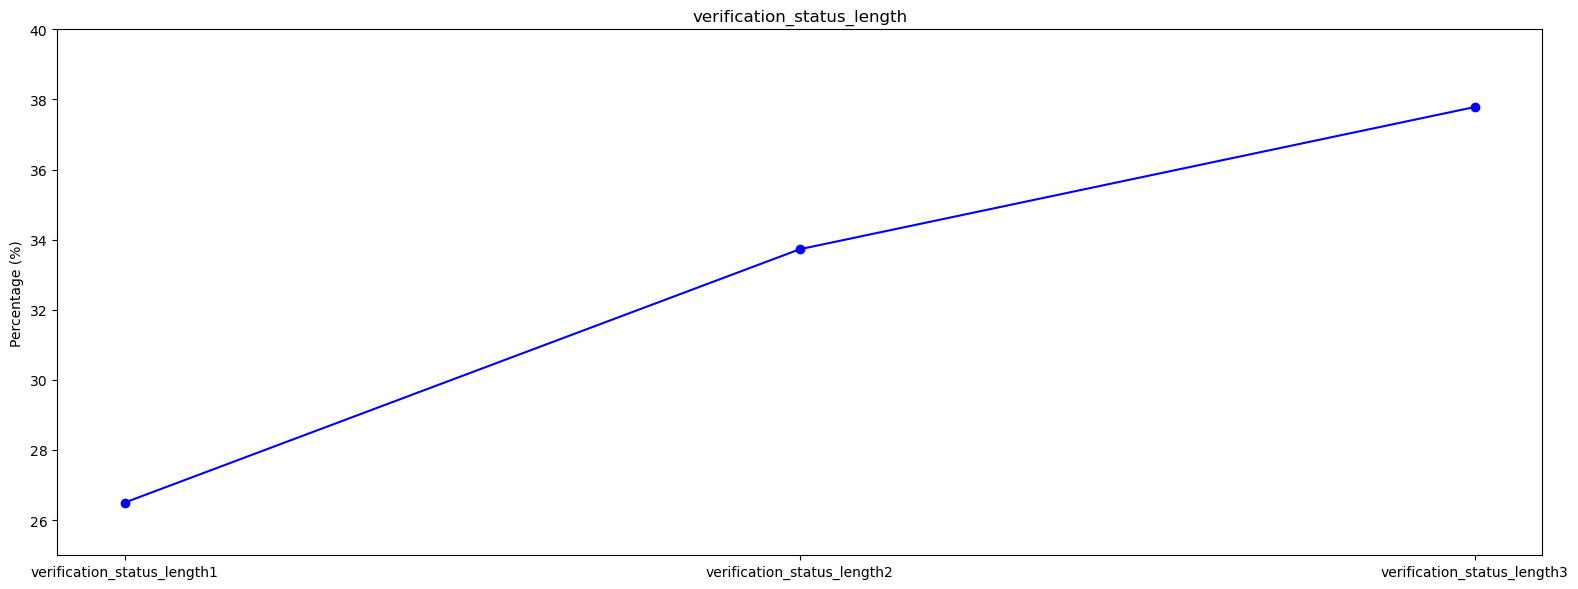

In [34]:
# 소득 발생 여부 및 형태가 어떤걸 뜻하는지 모르겠음 
# 다만 추세는 보임 

df_data = pd.DataFrame(list(data.items()), columns=['verification_status', 'percent'])

plt.figure(figsize=(16, 6))
plt.plot(df_data['verification_status'], df_data['percent'], marker='o', linestyle='-', color='b')
plt.ylabel('Percentage (%)')
plt.title('verification_status_length')
plt.ylim(25, 40)
plt.tight_layout()
plt.show()

### initial_list_status1 ~ 2 : 최초 대출 상태 (Initial listing status of the loan)

In [35]:
fc = [col for col in df.columns if 'initial_list_status' in col] + ['depvar']
df6 = df[fc]
df6.head()

,initial_list_status1,initial_list_status2,depvar
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,1
4,0,1,1


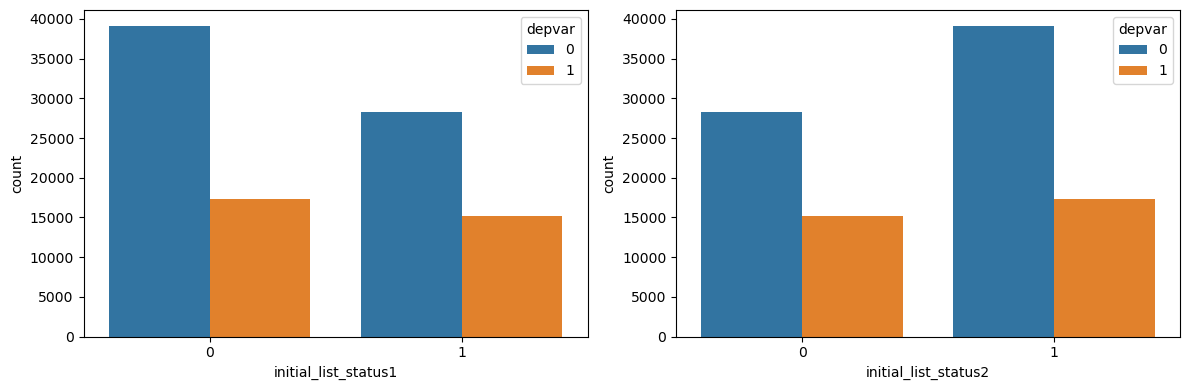

In [36]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

for i, column in enumerate(numeric(df6)[:-1]):
    row, col = i // 2, i % 2
    sns.countplot(data = df6, x = column, hue='depvar', ax = axs[col])
    
plt.tight_layout()
plt.show()

In [37]:
def get_initial_list_status_length(row):
    for i in range(1, 3):
        if row[f'initial_list_status{i}'] == 1:
            return i
    return 0  

def initial_list_status_length(df):
    df['initial_list_status_length'] = df.apply(get_initial_list_status_length, axis=1)
    df.drop(columns= ['initial_list_status1','initial_list_status2'], axis = 1, inplace = True)
    
initial_list_status_length(df6)
df6.head()

,depvar,initial_list_status_length
0,0,2
1,0,2
2,0,2
3,1,2
4,1,2


initial_list_status1 : 34.949 %
initial_list_status2 : 30.741 %


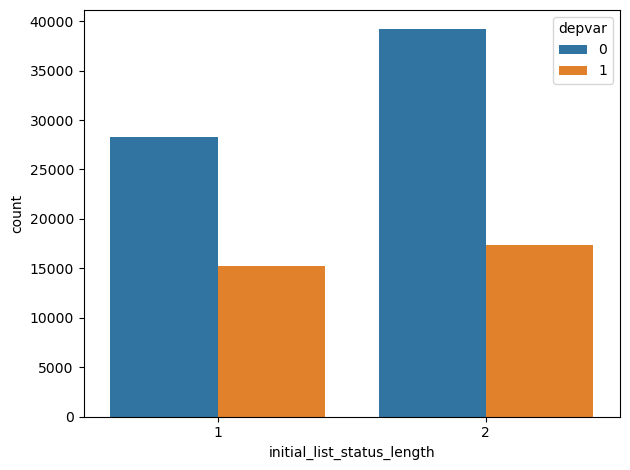

In [38]:
for i in range(1, 3):
    col = f'initial_list_status{i}'
    cond = df6['initial_list_status_length'] == i
    result = len(df6[cond][df6['depvar'] == 1]) / len(df6[cond]) * 100
    print('{} : {:.3f} %'.format(col, result))
    data[col] = result

sns.countplot(data = df6, x = 'initial_list_status_length', hue = 'depvar')
plt.tight_layout()
plt.show()

### collections_12_mths_ex_med : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. Thisexcludes medical collections)  
### acc_now_delinq : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)  
### chargeoff_within_12_mths : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for thesecondary applicant)  
### inq_last_6mths : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)  


In [39]:
df7 = df[['collections_12_mths_ex_med', 'acc_now_delinq','chargeoff_within_12_mths', 'inq_last_6mths','depvar']]
df7.head()

,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,inq_last_6mths,depvar
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,3,0
3,0,0,0,2,1
4,0,0,0,1,1


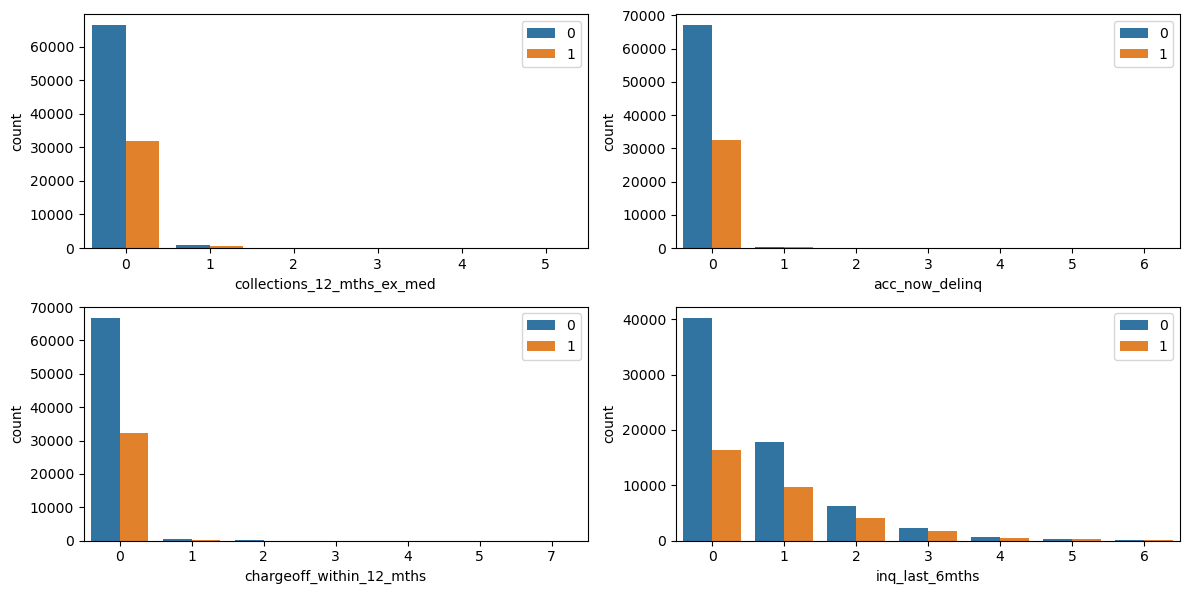

In [40]:
fig, axs = plt.subplots(2, 2, figsize = (12, 6))

for i, column in enumerate(numeric(df7)[:-1]):
    row, col = i // 2, i % 2
    sns.countplot(data = df7, x = column, hue = 'depvar', ax = axs[row, col])
    axs[row, col].legend(loc='upper right')
    
plt.tight_layout()
plt.show()

### 2

In [41]:
fd = [col for col in df.columns if df[col].nunique() >= 20] + ['depvar']
df8 = df[fd]
df8.head()

,int_rate,annual_inc,dti,delinq_2yrs,pub_rec,revol_bal,total_acc,tot_coll_amt,tot_cur_bal,delinq_amnt,...,total_rec_late_fee,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,0,3016,26,0,11773,0,...,0.0,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,5722,24,0,21875,0,...,0.0,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,0,6511,18,0,31868,0,...,0.0,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,0,6849,30,0,326049,0,...,0.0,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,2,8197,12,2506,8840,0,...,0.0,8,335.45,0.416,0.0,0.0,871.04,660,664,1


In [42]:
df8.columns

Index(['int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'pub_rec', 'revol_bal',
       'total_acc', 'tot_coll_amt', 'tot_cur_bal', 'delinq_amnt', 'tax_liens',
       'funded_amnt', 'funded_amnt_inv', 'total_rec_late_fee', 'open_acc',
       'installment', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_rec_int', 'fico_range_low', 'fico_range_high', 'depvar'],
      dtype='object')

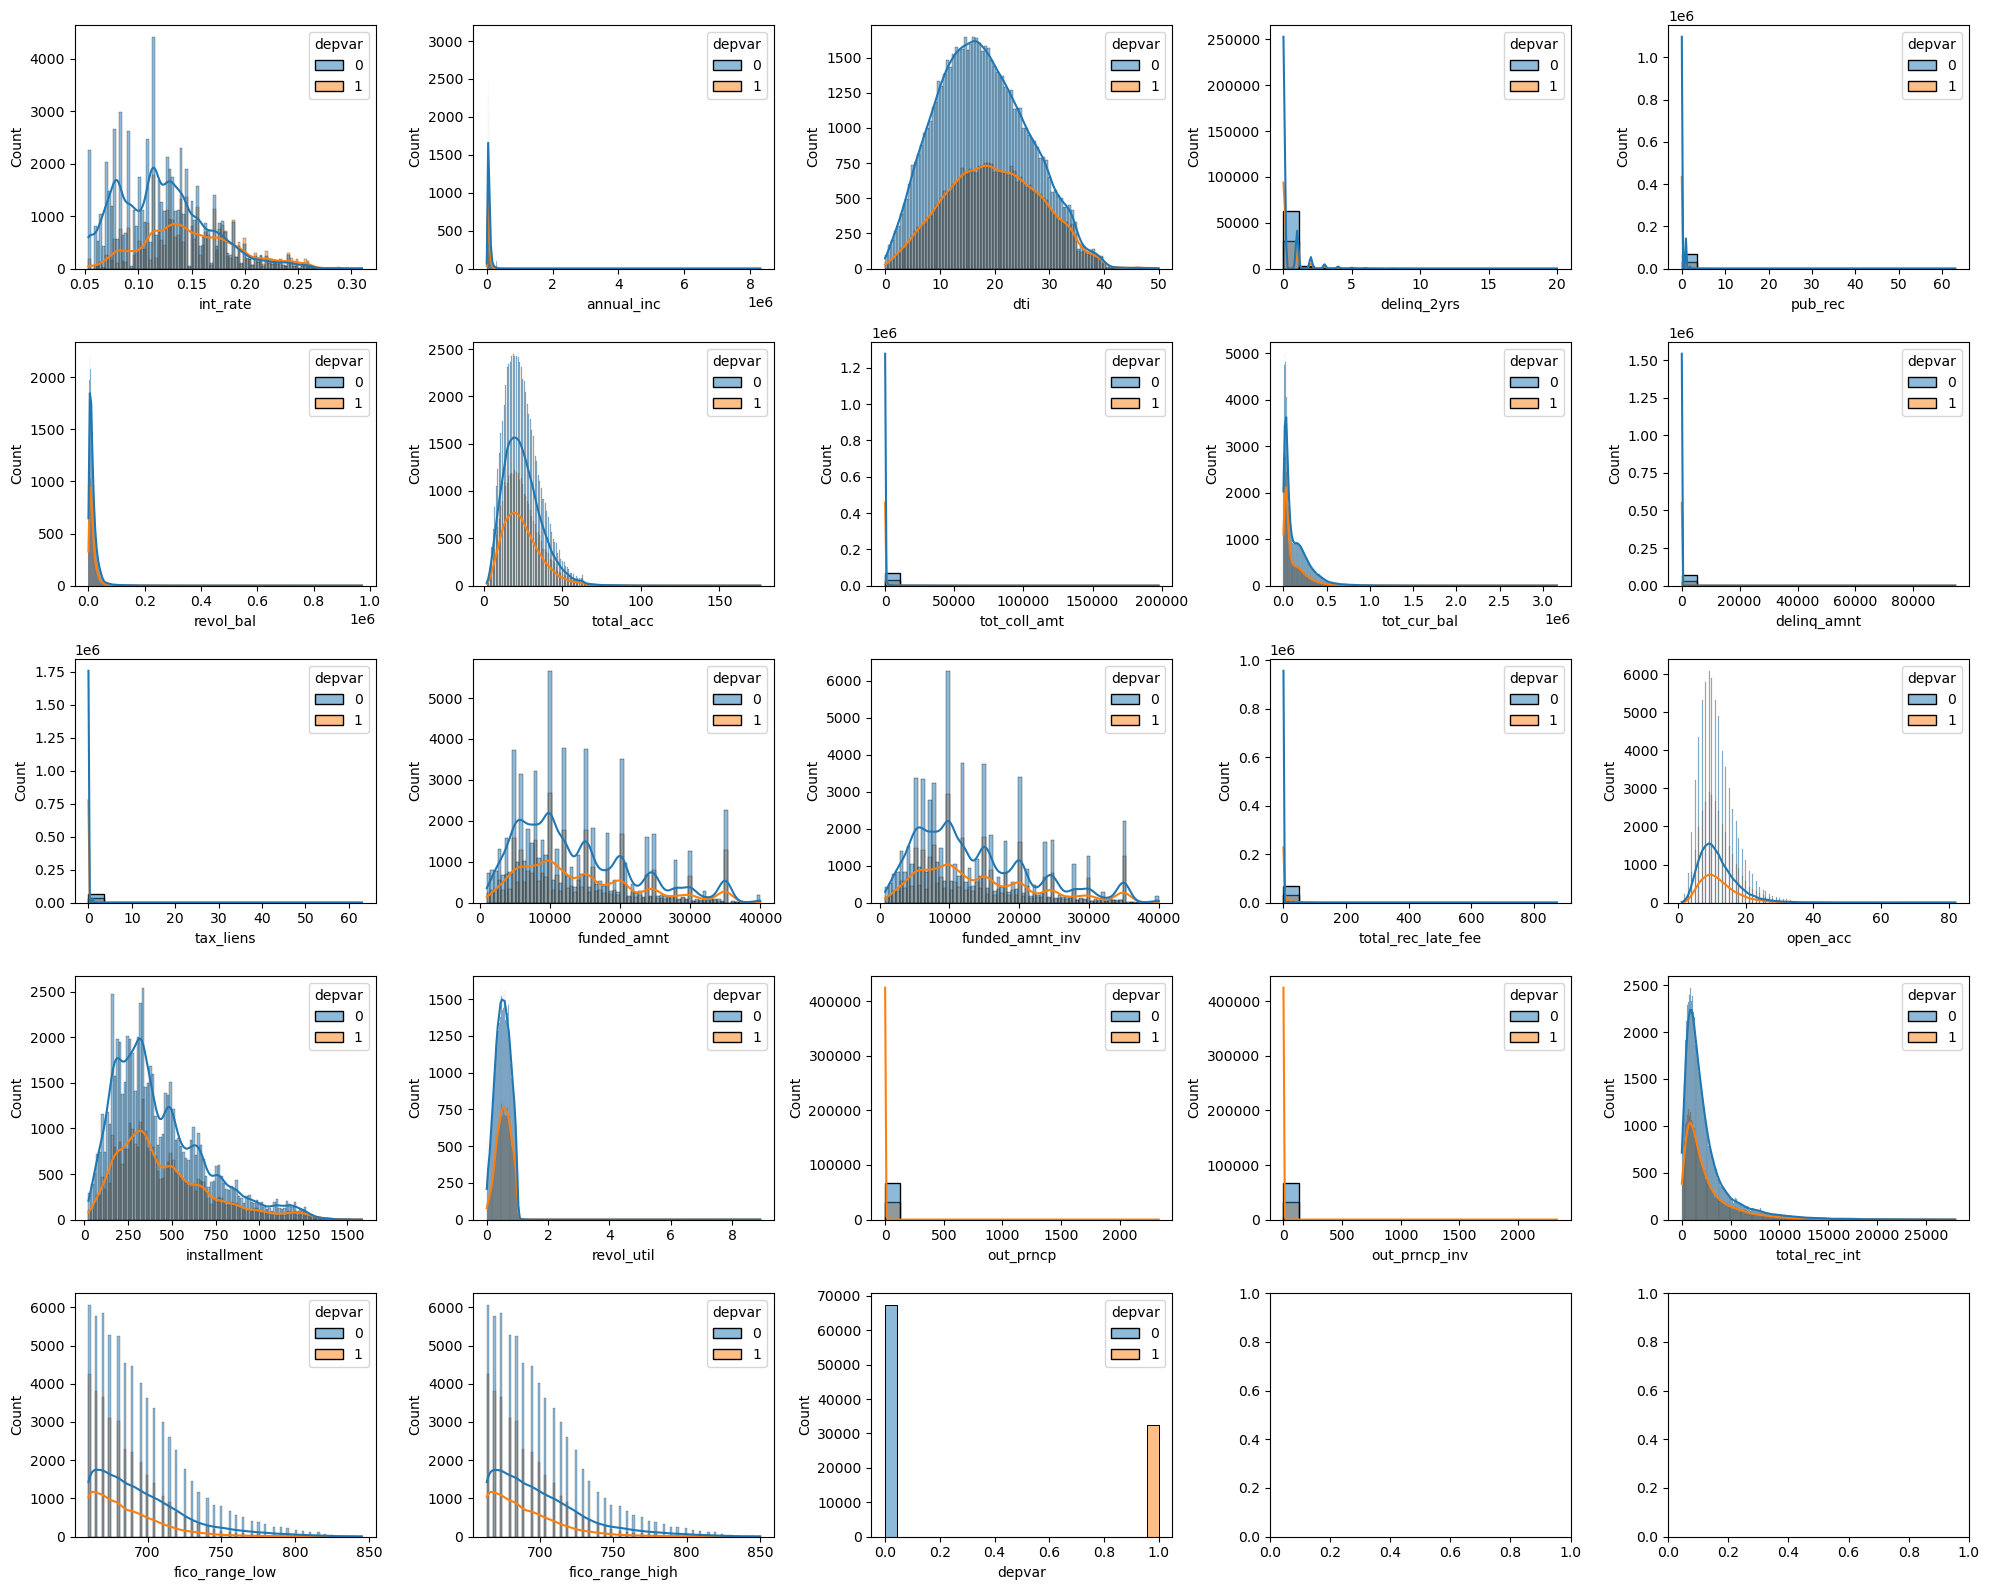

In [45]:
fig, axs = plt.subplots(5, 5, figsize = (20, 16))

for i, column in enumerate(numeric(df8)):
    row, col = i // 5, i % 5
    
    sns.histplot(data = df8, x = column, hue='depvar', kde = True, ax = axs[row, col])
    
plt.tight_layout()
plt.show()

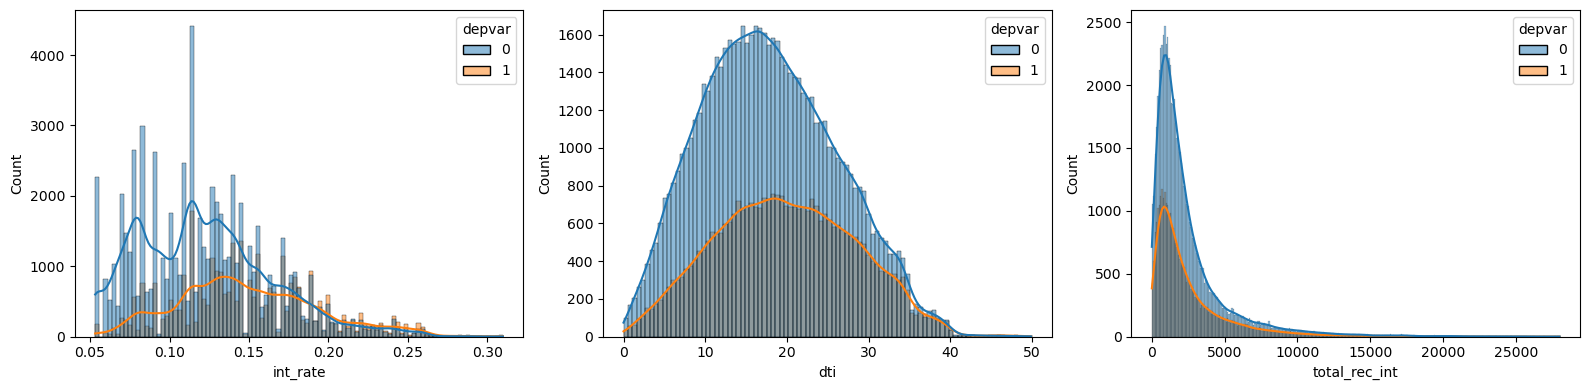

In [48]:
# int_rate            	0.277944
# total_rec_late_fee	0.123072
# dti	                0.110809

fig, axs = plt.subplots(1, 3, figsize = (16, 4))

cond = ['int_rate', 'dti', 'total_rec_int']
for i, column in enumerate(cond):
    row, col = i // 3, i % 3
    
    sns.histplot(data = df8, x = column, hue='depvar', kde = True, ax = axs[col])
    
plt.tight_layout()
plt.show()